In [1]:
import matplotlib.pyplot as plt
import numpy as np
import snntorch as snn
import snntorch.functional as SF
from snntorch import spikeplot as splt
import snntorch.spikegen as spikegen
import torch
from torch import nn
from torch.optim import Adam

In [4]:
class MultimodalIntegration(nn.Module):
	"""
	Combine the outputs from the visual and auditory encoders into a single multimodal representation.
	"""

	def __init__(self, input_size, hidden_size, output_size, beta):
		super(MultimodalIntegration, self).__init__()

		self.flatten = nn.Flatten()
		self.fc1 = nn.Linear(input_size, hidden_size)
		self.lif1 = snn.Leaky(beta=beta)
		self.fc2 = nn.Linear(hidden_size, hidden_size)
		self.lif2 = snn.Leaky(beta=beta)
		self.fc3 = nn.Linear(hidden_size, output_size)
		self.lif3 = snn.Leaky(beta=beta)

	def forward(self, x):
		x = self.flatten(x.to(torch.float32))
		#print(f"Shape after flattening: {x.shape}")
		mem1 = self.lif1.init_leaky()
		mem2 = self.lif2.init_leaky()
		mem3 = self.lif3.init_leaky()
		cur1 = self.fc1(x)
		spk1, mem1 = self.lif1(cur1, mem1)
		cur2 = self.fc2(spk1)
		spk2, mem2 = self.lif2(cur2, mem2)
		cur3 = self.fc3(spk2)
		spk3, mem3 = self.lif3(cur3, mem3)
		return spk3, mem3

In [2]:

# ## Hyperparameters
beta = 0.9  # Decay rate of the LIF neuron
hidden_size = 64  # Size of the hidden layer
output_size = 10  # Output size for the final multimodal representation
input_size = 40  # Correct input size based on concatenation of visual and auditory spikes

# Load the visual outputs file
sensory_data = np.load('paired_input_noise_0p1.npy')
all_labels = np.load('all_labels.npy')
labels = all_labels[1,:].copy()

In [8]:
device = torch.device('cpu')

# Concatenate the encoded spikes
combined_spikes = torch.from_numpy(sensory_data).to(device)

net = MultimodalIntegration(input_size, hidden_size, output_size, beta).to(device)

In [9]:

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.01)

targets = torch.from_numpy(labels).to(device)

In [10]:
# Training loop
num_epochs = 5
# num_samples = min(vis_spikes.shape[0], aud_spikes.shape[0], targets.shape[0])  # Use the minimum size across datasets 512
#num_samples = 3000

num_steps = 81  # Number of timesteps for the spike train

for epoch in range(num_epochs):
	epoch_loss = 0.0

	for i in range(np.size(sensory_data, 0)):

		target = targets[i].unsqueeze(0)

		# Initialize hidden states
		mem1 = net.lif1.init_leaky()
		mem2 = net.lif2.init_leaky()
		mem3 = net.lif3.init_leaky()

		# Accumulate loss over timesteps
		total_loss = 0.0
		optimizer.zero_grad()

		for t in range(num_steps):
			# Flatten the spike train for the current timestep
			input_t = combined_spikes[i,:,t].unsqueeze(0)

			# Forward pass through the network for each timestep
			spk3, mem3 = net(input_t)

			# Compute loss for this timestep
			loss = loss_fn(spk3, target.long())
			total_loss += loss

		# Backward pass and optimization
		optimizer.zero_grad()
		total_loss.backward()
		optimizer.step()

		epoch_loss += total_loss.item()

	avg_loss = epoch_loss / np.size(sensory_data, 0)
	print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')
	torch.save(net.state_dict(), f"mmSNN-epoch{epoch}"+'.pt')

print("Training complete")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch 1/5, Loss: 136.0239
Epoch 2/5, Loss: 130.6179
Epoch 3/5, Loss: 130.4937
Epoch 4/5, Loss: 130.0681
Epoch 5/5, Loss: 130.1269
Training complete


In [11]:
batch = 512
correct_preds = 0
false_preds = 0
with torch.no_grad():
  net.eval()
  for i in range(np.size(sensory_data, 0)):
    target = targets[i].unsqueeze(0)
    for t in range(num_steps):
      input = combined_spikes[i,:,t].unsqueeze(0)
      spk, mem = net(input)
      if np.argmax(mem) == target:
        correct_preds += 1
      else:
        false_preds += 1

correct_preds / (correct_preds + false_preds)

0.8365113811728395

In [70]:
noise = np.ones(20, dtype=int)
noise[:10] = 0
np.random.shuffle(noise)
noise * 10

noise_mask = np.repeat(noise[:, np.newaxis], 81, axis=1)
nm = np.repeat(noise_mask[np.newaxis, :, :], 2560, axis=0)
print(type(nm))
noise = np.concatenate((np.ones((2560, 20, 81)), nm), axis=1).astype(bool)
print(noise.shape)

<class 'numpy.ndarray'>
(2560, 40, 81)


In [75]:
# noisy_sensory_data = np.load('paired_input_noise_0p2.npy')
noisy_sensory_data = sensory_data * noise
# print(noisy_sensory_data)
noisy_combined_spikes = torch.from_numpy(noisy_sensory_data[:,]).to(device)

In [76]:
batch = 512
correct_preds = 0
false_preds = 0
with torch.no_grad():
  net.eval()
  for i in range(np.size(noisy_sensory_data, 0)):
    target = targets[i].unsqueeze(0)
    for t in range(num_steps):
      input = noisy_combined_spikes[i,:,t].unsqueeze(0)
      spk, mem = net(input)
      if np.argmax(mem) == target:
        correct_preds += 1
      else:
        false_preds += 1

print("on noisy data")
correct_preds / (correct_preds + false_preds)

on noisy data


0.8432146990740741

## EVAL

In [104]:
state_dict = torch.load("mmSNN-epoch4"+'.pt')
eval_net = MultimodalIntegration(input_size, hidden_size, output_size, beta).to(device)
eval_net.load_state_dict(state_dict)

<All keys matched successfully>

In [127]:
def gen_noise_mask(noise_pct, vision = True):
    noise = np.ones(20, dtype=int)
    noise[:int(20*noise_pct)] = 0
    np.random.shuffle(noise)

    noise_mask = np.repeat(noise[:, np.newaxis], 81, axis=1)
    nm = np.repeat(noise_mask[np.newaxis, :, :], 2560, axis=0)
    if vision:
        noise = np.concatenate((nm, np.ones((2560, 20, 81))), axis=1).astype(bool)
    else:
        noise = np.concatenate((np.ones((2560, 20, 81)), nm), axis=1).astype(bool)

    return noise

def eval(net, noisy_sensory_data, noisy_combined_spikes):
    batch = 512
    correct_preds = 0
    false_preds = 0
    with torch.no_grad():
        net.eval()
        for i in range(np.size(noisy_sensory_data, 0)):
            if i==batch: return correct_preds / (correct_preds + false_preds)
            target = targets[i].unsqueeze(0)
            for t in range(num_steps):
                input = noisy_combined_spikes[i,:,t].unsqueeze(0)
                spk, mem = net(input)
                if np.argmax(mem) == target:
                    correct_preds += 1
                else:
                    false_preds += 1

    return correct_preds / (correct_preds + false_preds)

In [128]:
n_levels = [.1, .2, .3, .5, .7, .9, 1]

audio_noise = []
for n in n_levels:
    noise = gen_noise_mask(n, vision=False) 
    noisy_sensory_data = sensory_data * noise
    noisy_combined_spikes = torch.from_numpy(noisy_sensory_data[:,]).to(device)
    acc = eval(eval_net, noisy_sensory_data, noisy_combined_spikes)
    audio_noise.append(acc)
    print(f"noise {n}  acc {acc}")

noise 0.1  acc 0.8544560185185185
noise 0.2  acc 0.8536361882716049
noise 0.3  acc 0.8434124228395061
noise 0.5  acc 0.8347800925925926
noise 0.7  acc 0.824170524691358
noise 0.9  acc 0.7856385030864198
noise 1  acc 0.7804060570987654


In [129]:
visual_noise = []
print("noise in vision")
for n in n_levels:
    noise = gen_noise_mask(n, vision=True) 
    noisy_sensory_data = sensory_data * noise
    noisy_combined_spikes = torch.from_numpy(noisy_sensory_data[:,]).to(device)
    acc = eval(eval_net, noisy_sensory_data, noisy_combined_spikes)
    visual_noise.append(acc)
    print(f"noise {n}  acc {acc}")

noise in vision
noise 0.1  acc 0.8384934413580247
noise 0.2  acc 0.8201678240740741
noise 0.3  acc 0.8191550925925926
noise 0.5  acc 0.7765962577160493
noise 0.7  acc 0.6385030864197531
noise 0.9  acc 0.4851707175925926
noise 1  acc 0.41030092592592593


Text(0.5, 1.0, 'accuracy v single-sense dropout pct')

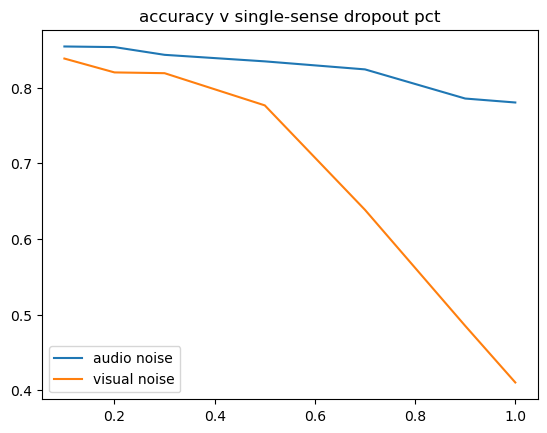

In [130]:
# audio_noise = [0.8539255401234568, 0.8502604166666666, 0.8532021604938271, 0.845727237654321, 0.7804060570987654]
# visual_noise = [0.8403983410493827, 0.8411699459876543, 0.8059413580246914, 0.7978153935185185, 0.41030092592592593]
plt.plot(n_levels, audio_noise, label="audio noise")
plt.plot(n_levels, visual_noise, label="visual noise")
plt.legend()
plt.title("accuracy v single-sense dropout pct")

## Forgetting

In [155]:
noise = gen_noise_mask(1, vision=True) 
noisy_sensory_data = (sensory_data * noise) + (noise - 1)
noisy_combined_spikes = torch.from_numpy(noisy_sensory_data[:,]).to(device)


In [156]:
state_dict = torch.load("mmSNN-epoch4"+'.pt')
net = MultimodalIntegration(input_size, hidden_size, output_size, beta).to(device)
net.load_state_dict(state_dict)

<All keys matched successfully>

In [157]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.05)

# Initialize list to store weights
weights_history = []
current_weights = {name: param.clone().detach() for name, param in net.state_dict().items()}
weights_history.append(current_weights)

net.train()

# Training loop
for epoch in range(3):
    # Training code here
    epoch_loss = 0.0

    for i in range(np.size(noisy_sensory_data, 0)):

        target = targets[i].unsqueeze(0)

        # Initialize hidden states
        mem1 = net.lif1.init_leaky()
        mem2 = net.lif2.init_leaky()
        mem3 = net.lif3.init_leaky()

        # Accumulate loss over timesteps
        total_loss = 0.0
        optimizer.zero_grad()

        for t in range(num_steps):
            # Flatten the spike train for the current timestep
            input_t = noisy_combined_spikes[i,:,t].unsqueeze(0)
            # Forward pass through the network for each timestep
            spk3, mem3 = net(input_t)

            # Compute loss for this timestep
            loss = loss_fn(spk3, target.long())
            total_loss += loss

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()

    avg_loss = epoch_loss / np.size(noisy_sensory_data, 0)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')
    
    # Store a deep copy of the model's weights
    current_weights = {name: param.clone().detach() for name, param in net.state_dict().items()}
    weights_history.append(current_weights)

Epoch 1/5, Loss: 178.4227
Epoch 2/5, Loss: 176.0206
Epoch 3/5, Loss: 170.2694


In [158]:
acc = eval(net, sensory_data, combined_spikes)
print(f"noise 0  acc {acc}")

acc = eval(net, noisy_sensory_data, noisy_combined_spikes)
print(f"noise 0.5  acc {acc}")

noise 0  acc 0.34859664351851855
noise 0.5  acc 0.31512827932098764


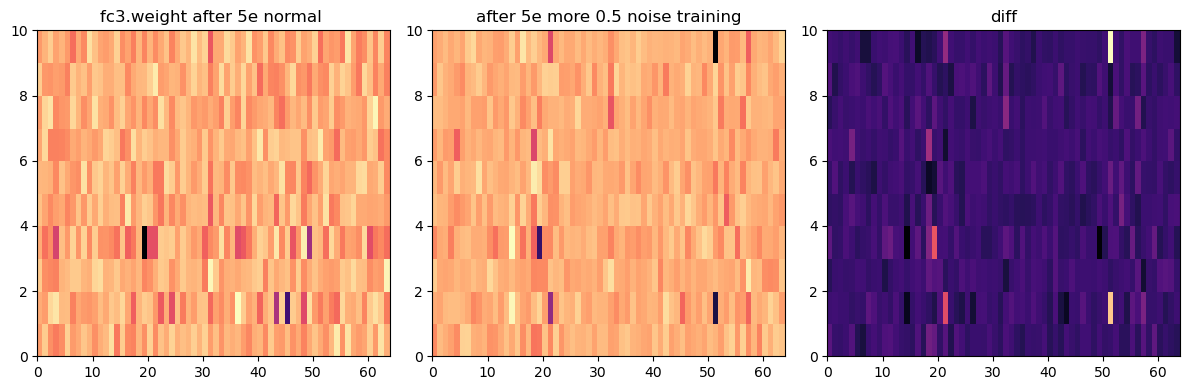

In [161]:
name_layer = 'fc3.weight'

fig, axs = plt.subplots(1, 3, figsize=(12,4))
cc = "magma"
heatmap = axs[0].pcolor(weights_history[0][name_layer].numpy(), cmap=cc)
# axs[0].colorbar(heatmap)
axs[0].set_title(f"{name_layer} after 5e normal ")
heatmap = axs[1].pcolor(weights_history[-1][name_layer].numpy(), cmap=cc)

diff = weights_history[0][name_layer] - weights_history[-1][name_layer]
heatmap = axs[2].pcolor(diff.numpy(), cmap=cc)

# plt.title("Change in first layer weights")
axs[1].set_title("after 5e more 0.5 noise training")
axs[2].set_title("diff")

plt.tight_layout()
plt.show()


In [ ]:
weight_diffs = []

for i in range(1, len(weights_history)):
    diff = {name: weights_history[i][name] - weights_history[i-1][name] for name in weights_history[i].keys()}
    weight_diffs.append(diff)

Text(0.5, 1.0, 'Change in first layer weights')

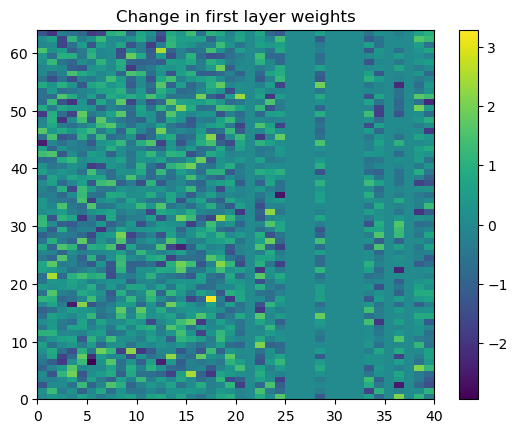

In [84]:
diff = weights_history[0]["fc1.weight"] - weights_history[-2]["fc1.weight"]
heatmap = plt.pcolor(diff.numpy())
plt.colorbar(heatmap)
plt.title("Change in first layer weights")

In [118]:
print(weights_history[0].keys())

dict_keys(['fc1.weight', 'fc1.bias', 'lif1.threshold', 'lif1.graded_spikes_factor', 'lif1.reset_mechanism_val', 'lif1.beta', 'fc2.weight', 'fc2.bias', 'lif2.threshold', 'lif2.graded_spikes_factor', 'lif2.reset_mechanism_val', 'lif2.beta', 'fc3.weight', 'fc3.bias', 'lif3.threshold', 'lif3.graded_spikes_factor', 'lif3.reset_mechanism_val', 'lif3.beta'])
